# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [1]:
from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## CONTENTS

* Overview
* Problem
* Node
* Uniform Cost Search
* Greedy Best First Search
* A\* Search

Reference to some extra materials on this topic:

https://skerritt.blog/greedy-algorithms/

https://www.geeksforgeeks.org/a-search-algorithm/

https://blog.goodaudience.com/solving-8-puzzle-using-a-algorithm-7b509c331288

## OVERVIEW

Here, we learn about a specific kind of problem solving - building goal-based agents that can plan ahead to solve problems. In particular, we examine navigation problem/route finding problem. We must begin by precisely defining **problems** and their **solutions**. We will look at several general-purpose search algorithms.

Search algorithms can be classified into two types:

* **Uninformed search algorithms**: Search algorithms which explore the search space without having any information about the problem other than its definition.
    * Examples:
        1. Breadth First Search
        2. Depth First Search
        3. Depth Limited Search
        4. Iterative Deepening Search


* **Informed search algorithms**: These type of algorithms leverage any information (heuristics, path cost) on the problem to search through the search space to find the solution efficiently.
    * Examples:
        1. Best First Search
        2. Uniform Cost Search
        3. A\* Search
        4. Recursive Best First Search

*Don't miss the visualisations of these algorithms solving the route-finding problem defined on Romania map at the end of this notebook.*

For visualisations, we use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works. These are imported as required in `notebook.py`.

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

## PROBLEM

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [3]:
psource(Problem)

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor`. It is the first method called when you create an instance of the class as `Problem(initial, goal)`. The variable `initial` specifies the initial state $s_0$ of the search problem. It represents the beginning state. From here, our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Return a boolean for a given state - `True` if it is a goal state, else `False`.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test.

## NODE

Let's see how we define a Node. Run the next cell to see how abstract class `Node` is defined in the search module.

In [4]:
psource(Node)

The `Node` class has nine methods. The first is the `__init__` method.

* `__init__(self, state, parent, action, path_cost)` : This method creates a node. `parent` represents the node that this is a successor of and `action` is the action required to get from the parent node to this node. `path_cost` is the cost to reach current node from parent node.

The next 4 methods are specific `Node`-related functions.

* `expand(self, problem)` : This method lists all the neighbouring(reachable in one step) nodes of current node. 

* `child_node(self, problem, action)` : Given an `action`, this method returns the immediate neighbour that can be reached with that `action`.

* `solution(self)` : This returns the sequence of actions required to reach this node from the root node. 

* `path(self)` : This returns a list of all the nodes that lies in the path from the root to this node.

The remaining 4 methods override standards Python functionality for representing an object as a string, the less-than ($<$) operator, the equal-to ($=$) operator, and the `hash` function.

* `__repr__(self)` : This returns the state of this node.

* `__lt__(self, node)` : Given a `node`, this method returns `True` if the state of current node is less than the state of the `node`. Otherwise it returns `False`.

* `__eq__(self, other)` : This method returns `True` if the state of current node is equal to the other node. Else it returns `False`.

* `__hash__(self)` : This returns the hash of the state of current node.

We will use the abstract class `Problem` to define our real **problem** named `GraphProblem`. You can see how we define `GraphProblem` by running the next cell.

In [5]:
psource(GraphProblem)

Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and neighbours as values.

**romania_map with Straight-line distance to Bucharest** 

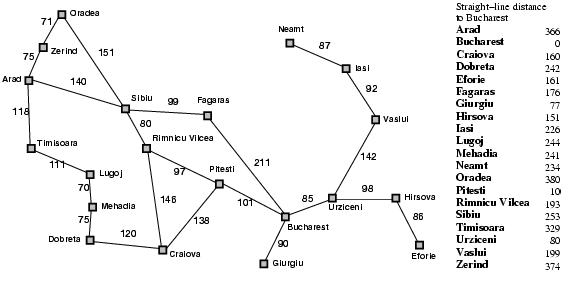

In [6]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.

**Define a problem:**
Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph. 

Say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [7]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

### Romania Map Visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [8]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [9]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

We can simply call the function with node_colors dictionary object to display it.

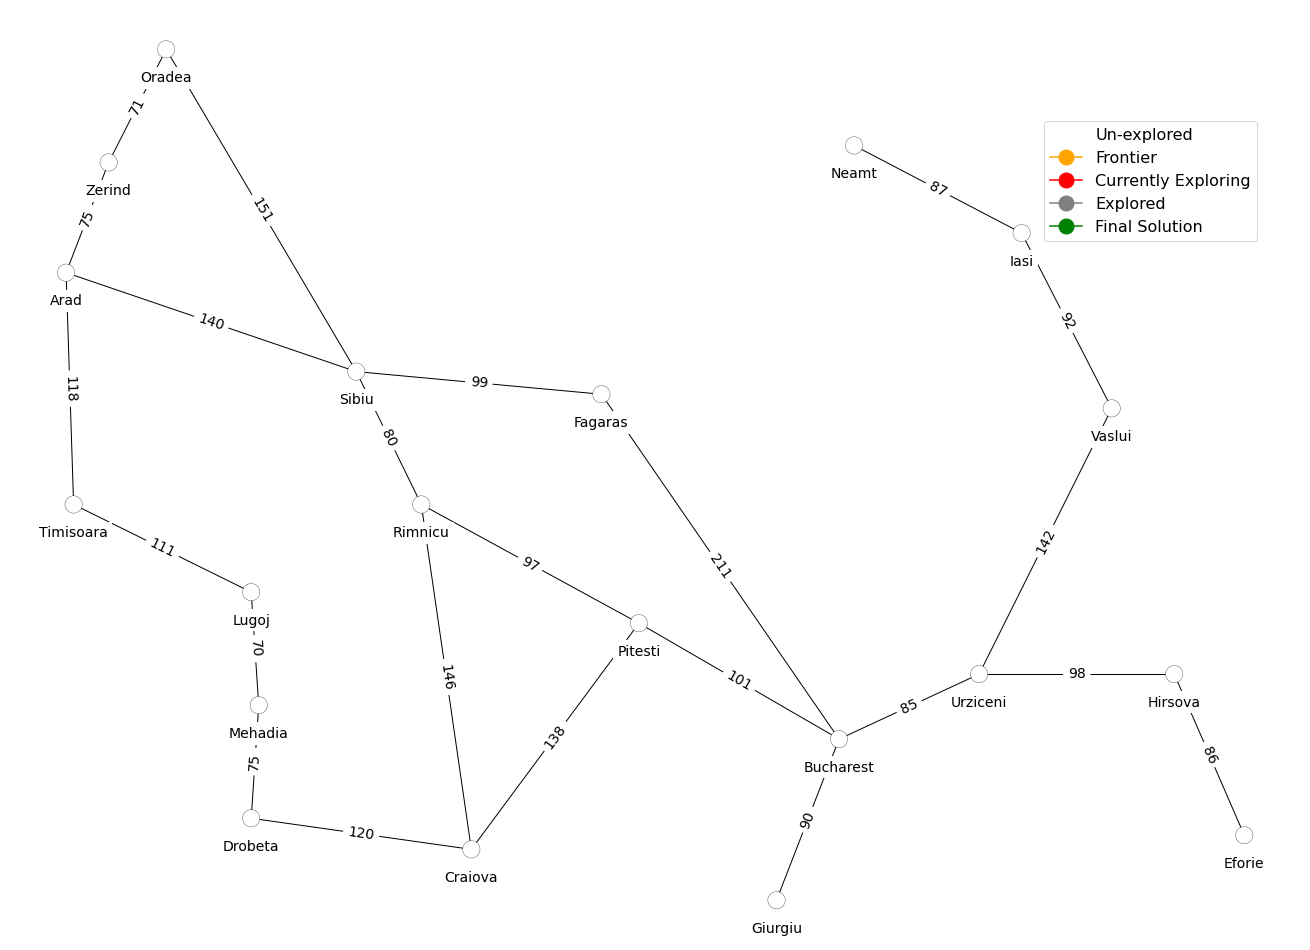

In [10]:
show_map(romania_graph_data)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

## SEARCHING ALGORITHMS VISUALIZATION

In this section, we have visualizations of the following searching algorithms:


6. Uniform Cost Search
9. Greedy Best First Search
9. A\*-Search


We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>

## 5. BEST FIRST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [11]:
def best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < incumbent:
                    del frontier[child]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

## 6. UNIFORM COST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [12]:
def uniform_cost_search_graph(problem):
    "[Figure 3.14]"
    #Uniform Cost Search uses Best First Search algorithm with f(n) = g(n)
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)


In [13]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=uniform_cost_search_graph, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 9. GREEDY BEST FIRST SEARCH
Let's change all the node_colors to starting position and define a different problem statement.

In [14]:
def greedy_best_first_search(problem, h=None):
    """Greedy Best-first graph search is an informative searching algorithm with f(n) = h(n).
    You need to specify the h function when you call best_first_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, lambda n: h(n))
    return(iterations, all_node_colors, node)


In [15]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=greedy_best_first_search, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 10. A\* SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [16]:
def astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)


In [17]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=astar_search_graph, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## A* HEURISTICS

Different heuristics provide different efficiency in solving A* problems which are generally defined by the number of explored nodes as well as the branching factor. With the classic 8 puzzle we can show the efficiency of different heuristics through the number of explored nodes.

### 8 Puzzle Problem

The *8 Puzzle Problem* consists of a 3x3 tray in which the goal is to get the initial configuration to the goal state by shifting the numbered tiles into the blank space.

example:- 

              Initial State                        Goal State
              | 7 | 2 | 4 |                       | 1 | 2 | 3 |
              | 5 | 0 | 6 |                       | 4 | 5 | 6 |
              | 8 | 3 | 1 |                       | 7 | 8 | 0 |
              
We have a total of 9 blank tiles giving us a total of 9! initial configuration but not all of these are solvable. The solvability of a configuration can be checked by calculating the Inversion Permutation. If the total Inversion Permutation is even then the initial configuration is solvable else the initial configuration is not solvable which means that only 9!/2 initial states lead to a solution.
<br>
Let's define our goal state.

In [18]:
goal = [1, 2, 3, 4, 5, 6, 7, 8, 0]

#### Heuristics :-

1) Manhattan Distance:- For the 8 puzzle problem Manhattan distance is defined as the distance of a tile from its goal state( for the tile numbered '1' in the initial configuration Manhattan distance is 4 "2 for left and 2 for upward displacement").

2) No. of Misplaced Tiles:- The heuristic calculates the number of misplaced tiles between the current state and goal state.

3) Sqrt of Manhattan Distance:- It calculates the square root of Manhattan distance.

4) Max Heuristic:- It assign the score as the maximum between "Manhattan Distance" and "No. of Misplaced Tiles".

In [19]:
# Heuristics for 8 Puzzle Problem
import math

def linear(node):
    return sum([1 if node.state[i] != goal[i] else 0 for i in range(8)])

def manhattan(node):
    state = node.state
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = abs(index_goal[i][j] - index_state[i][j]) + mhd
    
    return mhd

def sqrt_manhattan(node):
    state = node.state
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = (index_goal[i][j] - index_state[i][j])**2 + mhd
    
    return math.sqrt(mhd)

def max_heuristic(node):
    score1 = manhattan(node)
    score2 = linear(node)
    return max(score1, score2)

We can solve the puzzle using the `astar_search` method.

In [20]:
# Solving the puzzle 
puzzle = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
puzzle.check_solvability((2, 4, 3, 1, 5, 6, 7, 8, 0)) # checks whether the initialized configuration is solvable or not

True

This case is solvable, let's proceed.
<br>
The default heuristic function returns the number of misplaced tiles.

In [21]:
astar_search(puzzle).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

In the following cells, we use different heuristic functions.
<br>

In [22]:
astar_search(puzzle, linear).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

In [23]:
astar_search(puzzle, manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [24]:
astar_search(puzzle, sqrt_manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [25]:
astar_search(puzzle, max_heuristic).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

Even though all the heuristic functions give the same solution, the difference lies in the computation time.
<br>
This might make all the difference in a scenario where high computational efficiency is required.
<br>
Let's define a few puzzle states and time `astar_search` for every heuristic function.
We will use the %%timeit magic for this.

In [26]:
puzzle_1 = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
puzzle_2 = EightPuzzle((1, 2, 3, 4, 5, 6, 0, 7, 8))
puzzle_3 = EightPuzzle((1, 2, 3, 4, 5, 7, 8, 6, 0))

The default heuristic function is the same as the `linear` heuristic function, but we'll still check both.

In [27]:
%%timeit
astar_search(puzzle_1)
astar_search(puzzle_2)
astar_search(puzzle_3)

2.2 ms ± 81.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%%timeit
astar_search(puzzle_1, linear)
astar_search(puzzle_2, linear)
astar_search(puzzle_3, linear)

2.11 ms ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%%timeit
astar_search(puzzle_1, manhattan)
astar_search(puzzle_2, manhattan)
astar_search(puzzle_3, manhattan)

1.74 ms ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%%timeit
astar_search(puzzle_1, sqrt_manhattan)
astar_search(puzzle_2, sqrt_manhattan)
astar_search(puzzle_3, sqrt_manhattan)

21 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%%timeit
astar_search(puzzle_1, max_heuristic)
astar_search(puzzle_2, max_heuristic)
astar_search(puzzle_3, max_heuristic)

1.92 ms ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We can infer that the `manhattan` heuristic function works the fastest.
<br>
`sqrt_manhattan` has an extra `sqrt` operation which makes it quite a lot slower than the others.
<br>
`max_heuristic` should have been a bit slower as it calls two functions, but in this case, those values were already calculated which saved some time.
Feel free to play around with these functions.

**Sample map.location values**

romania_map.locations = dict(
    Barstow=(91, 490), Riverside=(300, 327), Santabarbara=(253, 288),
    Malibu=(165, 299), Losangeles=(562, 293), Palmsprings=(305, 449),
    Elcajon=(375, 270), Sandiego=(534, 350))

**TASK 1 [50%]** 

*   Now create an Undirected Graph such as the romania_map, containing a dict of nodes as keys and neighbours as values.
*   Start exploring from Santa Barbara and try to find El Cajon in the map using.


*   Start exploring from Barstow and try to find El Cajon in the map.
*   Now show the visualisation of the map [Figure 1] from the task and see how different searching algorithms perform / how frontier expands in each of the following search algorithms:


> 1) A* Search

> 2) Greedy Best First Search



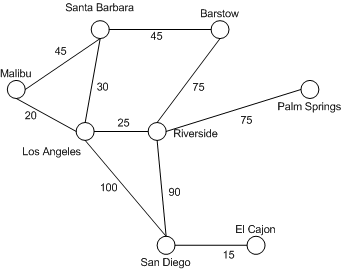

Fig 1: santa_barbara_map

In [32]:
santa_barbara_map = UndirectedGraph(dict(
    Barstow = dict(Riverside = 75, Santa_Barbara = 45),
    El_Cajon = dict(San_Diego = 15),
    Los_Angeles = dict(Malibu = 20,Riverside = 25, San_Diego = 100),
    Malibu = dict(Los_Angeles = 20, Santa_Barbara = 45),
    Palm_Springs = dict(Riverside = 75),
    Riverside = dict(Barstow = 75, Los_Angeles = 25, Palm_Springs = 75, San_Diego = 90),
    Santa_Barbara = dict(Barstow = 45, Malibu = 45,Los_Angeles = 30),
    San_Diego = dict(El_Cajon = 15, Los_Angeles = 100,Riverside = 90))) 

In [33]:
santa_barbara_map.locations = dict(
    Barstow=(240,530), El_Cajon=(270,300), Los_Angeles=(120,420),
    Malibu=(80,450), Palm_Springs=(280,450), Riverside=(200,420),
    Santa_Barbara=(131,530), San_Diego=(210,300))

In [34]:
santa_barbara_locations = santa_barbara_map.locations
print(santa_barbara_locations)

{'Barstow': (240, 530), 'El_Cajon': (270, 300), 'Los_Angeles': (120, 420), 'Malibu': (80, 450), 'Palm_Springs': (280, 450), 'Riverside': (200, 420), 'Santa_Barbara': (131, 530), 'San_Diego': (210, 300)}


In [35]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in santa_barbara_map.locations.keys()}
node_positions = santa_barbara_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in santa_barbara_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in santa_barbara_map.graph_dict.items() for k2, v2 in v.items()}

santa_barbara_graph_data = {  'graph_dict' : santa_barbara_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

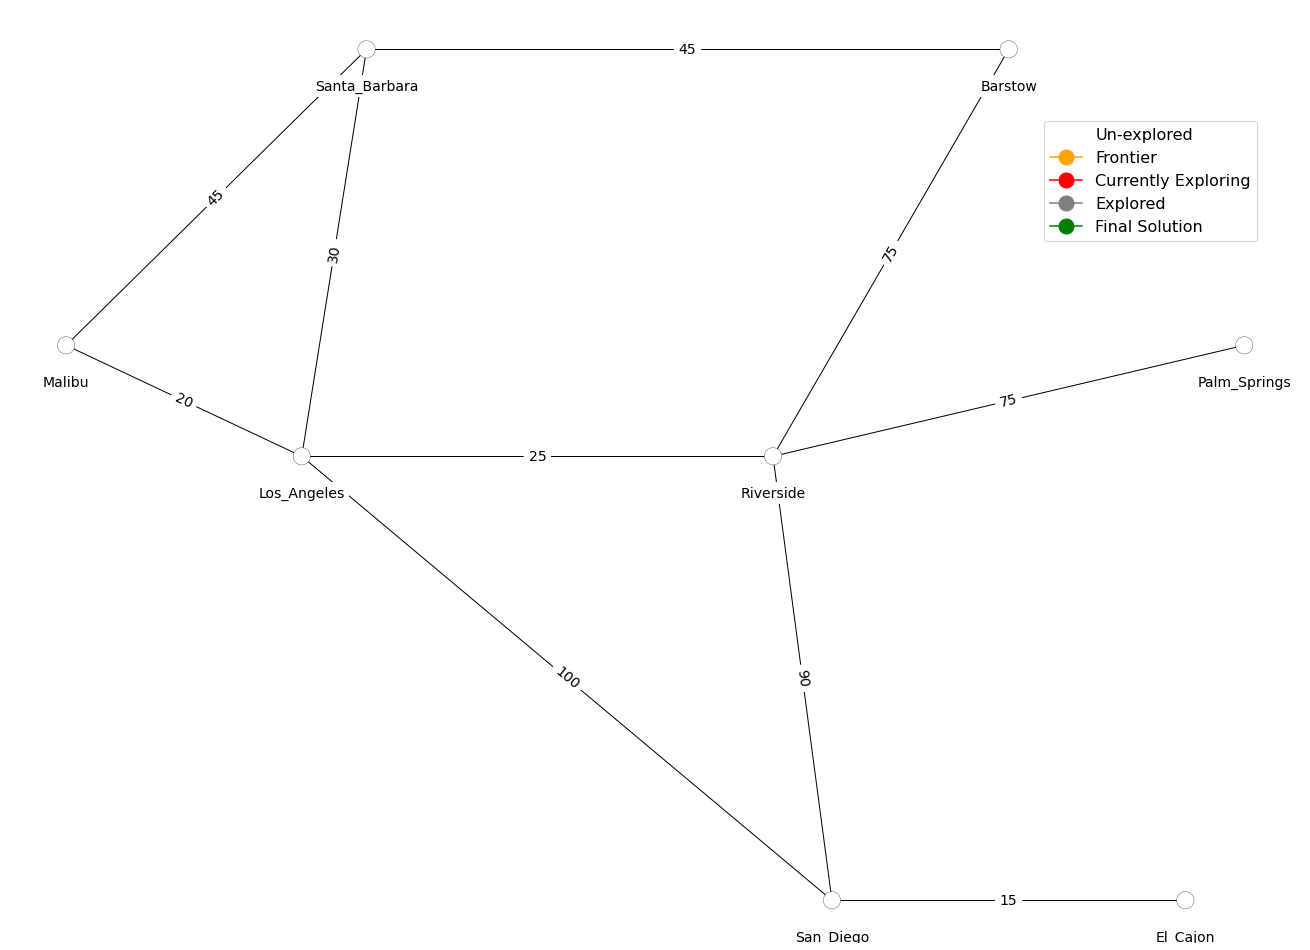

In [36]:
show_map(santa_barbara_graph_data)

## 1.A* Search

### Santa_Barbara to El_Cajon

In [37]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=astar_search_graph, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Barstow to El_Cajon

In [38]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=astar_search_graph, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 2.Greedy best first search

### Santa_Barbara to El_Cajon

In [39]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=greedy_best_first_search, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Barstow to El_Cajon

In [40]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=greedy_best_first_search, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

**TASK 2 [50%]**

*   Now create an Undirected Graph such as the romania_map, containing a dict of nodes as keys and neighbours as values.
*   Start exploring from Bordeaux and try to find Stasbourg  in the map using.
*   Start exploring from Brest and try to find Nice in the map.
*   Now show the visualisation of the map [Figure 1] from the task and see how different searching algorithms perform / how frontier expands in each of the following search algorithms:

> 1) A* Search

> 2) Greedy best first search







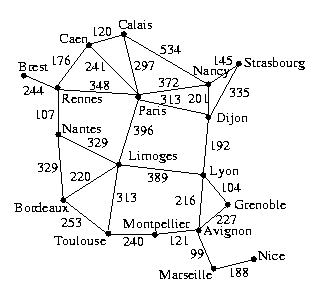

Fig 2: brest_map

In [41]:
brest_map = UndirectedGraph(dict(
    Avignon = dict(Grenoble = 227, Lyon = 104, Montpellier = 121),
    Bordeaux = dict(Limoges = 220,Nantes = 329,Toulouse = 253),
    Brest = dict(Rennes = 244),
    Caen = dict(Calais = 120,Paris = 241, Rennes = 176),
    Calais = dict(Caen = 120,Nancy = 534, Paris = 297),
    Dijon = dict(Nancy = 201, Paris = 313, Strasbourg = 335),
    Grenoble = dict (Avignon = 227, Lyon = 104),
    Limoges = dict(Bordeaux = 220,Lyon = 389,Nantes = 329,Paris = 396,Toulouse = 313),
    Lyon = dict(Dijon = 192,Grenoble = 104,Limoges = 389 ),
    Marseille = dict(Avignon = 99, Nice = 188),
    Montpellier = dict(Avignon = 121,Toulouse = 240),
    Nancy = dict(Calais = 534, Dijon = 201,Paris = 372, Strasbourg = 145),
    Nantes = dict(Bordeaux = 329, Limoges = 329,Rennes = 107),
    Nice = dict(Marseille = 188),
    Paris = dict(Caen = 241,Calais = 297,Dijon = 313,Limoges = 396, Nancy = 372,Rennes = 348),
    Rennes = dict(Brest = 244,Caen = 176,Nantes = 107, Paris = 348),
    Strasbourg = dict(Dijon = 335, Nancy = 145),
    Toulouse = dict(Bordeaux = 253,Limoges = 313,Montpellier = 240 )
))

brest_map.locations=dict(Calais=(240,530),Caen=(220,510),Nancy=(280,480),
                         Strasbourg=(300,500),Rennes=(200,480),Brest=(190,500),Paris=(250,470),Dijon=(280,450),
                         Lyon=(280,400),Nantes=(200,425),Limoges=(230,410),Bordeaux=(200,370),Grenoble=(300,370),
                         Avignon=(280,350),Montpellier=(250,350),Toulouse=(215,350),Marseille=(290,320),Nice=(320,330)
                        )

In [42]:
brest_locations = brest_map.locations
print(brest_locations)

{'Calais': (240, 530), 'Caen': (220, 510), 'Nancy': (280, 480), 'Strasbourg': (300, 500), 'Rennes': (200, 480), 'Brest': (190, 500), 'Paris': (250, 470), 'Dijon': (280, 450), 'Lyon': (280, 400), 'Nantes': (200, 425), 'Limoges': (230, 410), 'Bordeaux': (200, 370), 'Grenoble': (300, 370), 'Avignon': (280, 350), 'Montpellier': (250, 350), 'Toulouse': (215, 350), 'Marseille': (290, 320), 'Nice': (320, 330)}


In [43]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in brest_map.locations.keys()}
node_positions = brest_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in brest_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in brest_map.graph_dict.items() for k2, v2 in v.items()}

brest_graph_data = {  'graph_dict' : brest_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

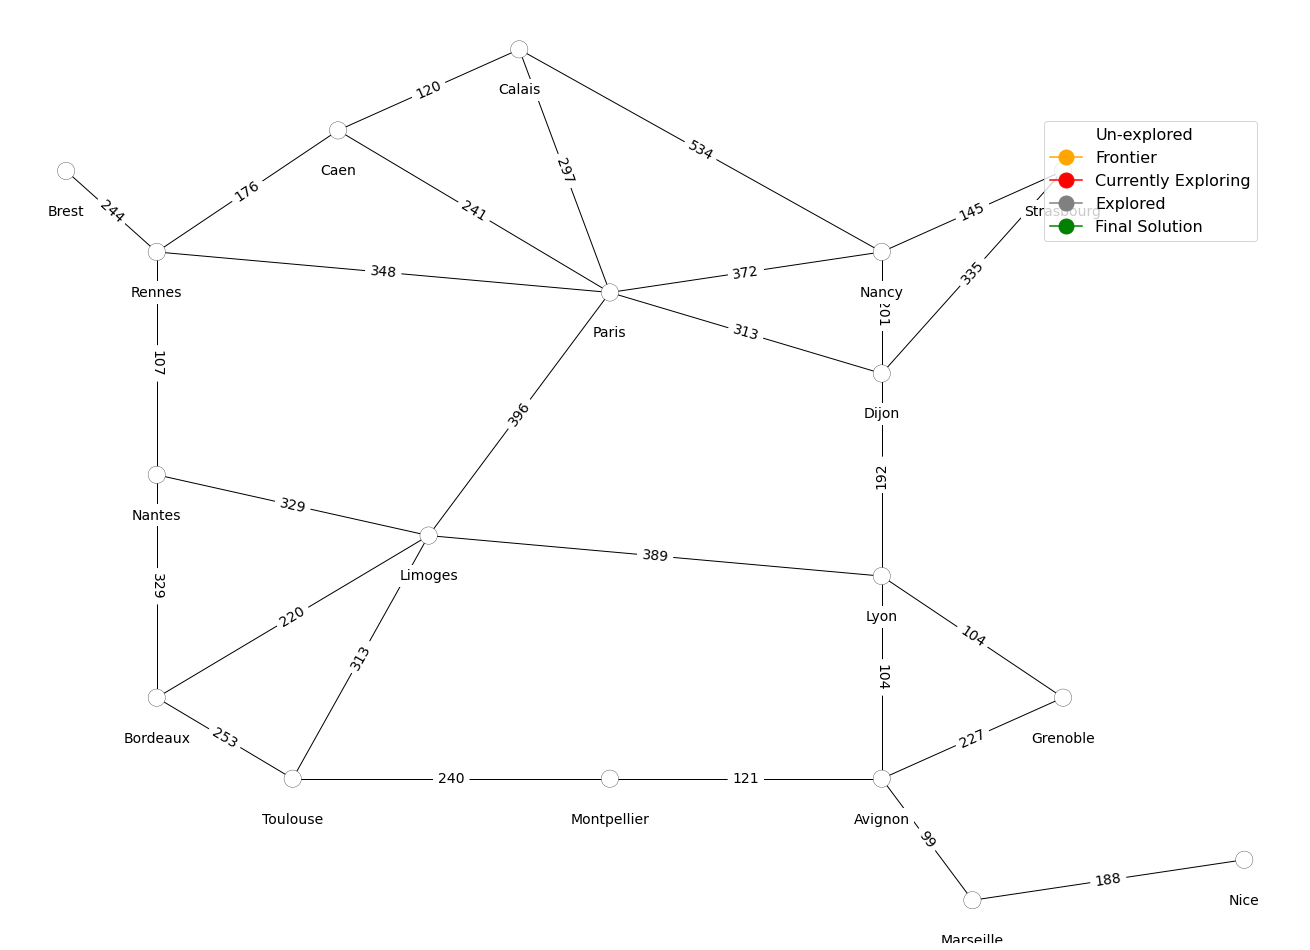

In [44]:
show_map(brest_graph_data)

## 1.A* Search

### Bordeaux to Strasbourg

In [45]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=astar_search_graph, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [46]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=astar_search_graph, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 2.Greedy best first search

### Bordeaux to Strasbourg

In [47]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=greedy_best_first_search, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [48]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=greedy_best_first_search, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…